In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [3]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [4]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


# Wrong Method

In [5]:
# Start by doing the wrong thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [6]:
# Normalize the data
# Note I didn't think about where the true boundary is, this is just approx
scalar = StandardScaler()
scalar.fit(series[:len(series) // 2])
series = scalar.transform(series).flatten()

In [7]:
# build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1) # make it N x T x D
Y = np.array(Y).reshape(-1,1)
N = len(X)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (1239, 20, 1), Y.shape: (1239, 1)


In [8]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
# try autoregressive RNN model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True
    )
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    # get RNN unit output
    # out is of size (N, T, M)
    # 2nd return value is hidden states of each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, (h0, c0))
    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:,-1,:])
    return out

In [10]:
# Instantiate the model
model = RNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
def full_gd(model, criterion,
            optimizer, X_train,
            y_train, X_test, y_test, epochs=200):
  # stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    # backward and optimize
    loss.backward()
    optimizer.step()
    # save losses
    train_losses[it] = loss.item()
    # test loss
    ouputs_test = model(X_test)
    loss_test = criterion(ouputs_test, y_test)
    test_losses[it] = loss_test.item()
    if (it + 1) % 5 == 0:
      print(f"Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss_test.item():.4f}")
  return train_losses, test_losses

In [13]:
# make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [14]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [15]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 1.1609, Test Loss: 7.6406
Epoch 10/200, Train Loss: 1.0313, Test Loss: 6.5509
Epoch 15/200, Train Loss: 0.9522, Test Loss: 5.9149
Epoch 20/200, Train Loss: 0.8886, Test Loss: 5.4980
Epoch 25/200, Train Loss: 0.8217, Test Loss: 5.1024
Epoch 30/200, Train Loss: 0.7393, Test Loss: 4.5779
Epoch 35/200, Train Loss: 0.6329, Test Loss: 3.8655
Epoch 40/200, Train Loss: 0.5032, Test Loss: 3.0040
Epoch 45/200, Train Loss: 0.3669, Test Loss: 2.0976
Epoch 50/200, Train Loss: 0.2544, Test Loss: 1.3437
Epoch 55/200, Train Loss: 0.1837, Test Loss: 0.8824
Epoch 60/200, Train Loss: 0.1586, Test Loss: 0.6794
Epoch 65/200, Train Loss: 0.1414, Test Loss: 0.6038
Epoch 70/200, Train Loss: 0.1173, Test Loss: 0.6170
Epoch 75/200, Train Loss: 0.0926, Test Loss: 0.6542
Epoch 80/200, Train Loss: 0.0747, Test Loss: 0.6585
Epoch 85/200, Train Loss: 0.0654, Test Loss: 0.5924
Epoch 90/200, Train Loss: 0.0527, Test Loss: 0.4790
Epoch 95/200, Train Loss: 0.0426, Test Loss: 0.3983
Epoch 100/200

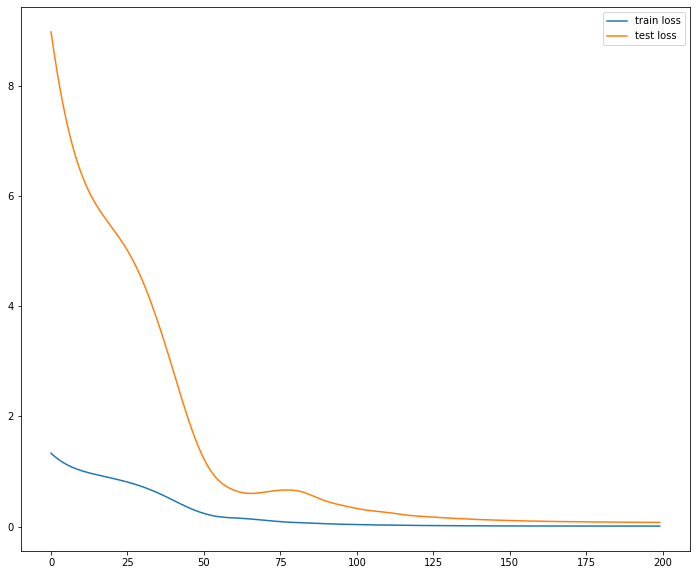

In [16]:
# plot the train loss and test loss per iteration
plt.figure(figsize=(12,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [17]:
# "wrong" one-step forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0
X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)
while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(1,T,1)
  p = model(input_)[0,0].item() # 1x1 arry -> scalar
  i += 1
  # update the predictions list
  validation_predictions.append(p)

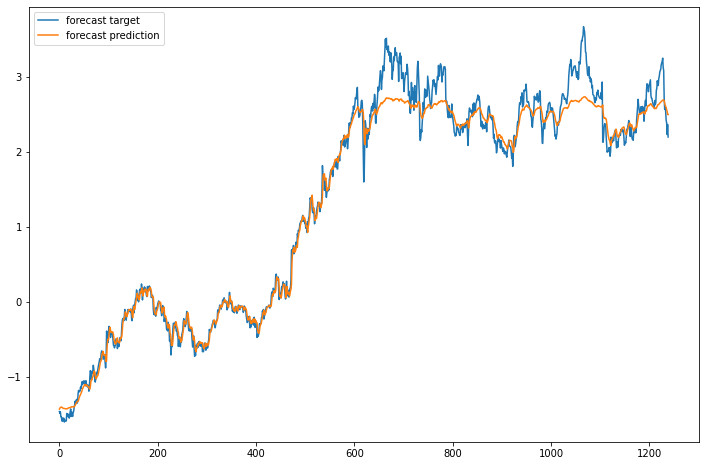

In [18]:
plt.figure(figsize=(12,8))
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()

In [19]:
# Multi-step forecast
# Forecast future values (use only self-predictions for making future predictions)
validation_target = Y[-N//2:]
validation_predictions = []
# last train input
# last_x = torch.from_numpy(X[-N//2]) # 1-D array of length T
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = X_test[0].view(T)
while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1,T,1)
  p = model(input_) # [0,0] 1x1 array -> scalar
  # update the predictions list
  validation_predictions.append(p[0,0].item())
  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

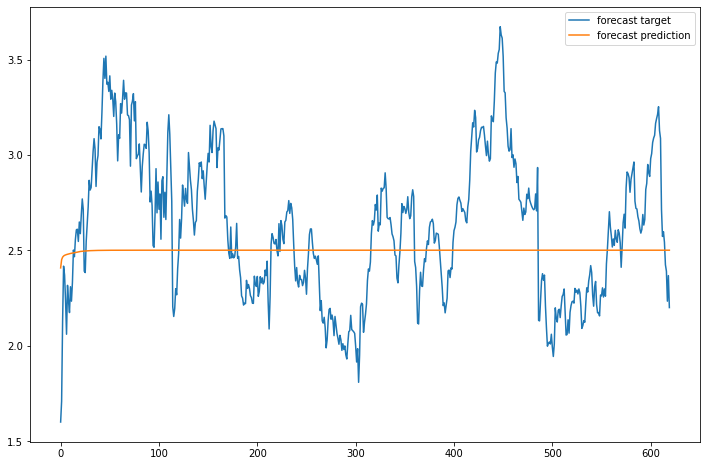

In [20]:
plt.figure(figsize=(12,8))
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()

# Returns

In [21]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [22]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1
# now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [23]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [24]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [25]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


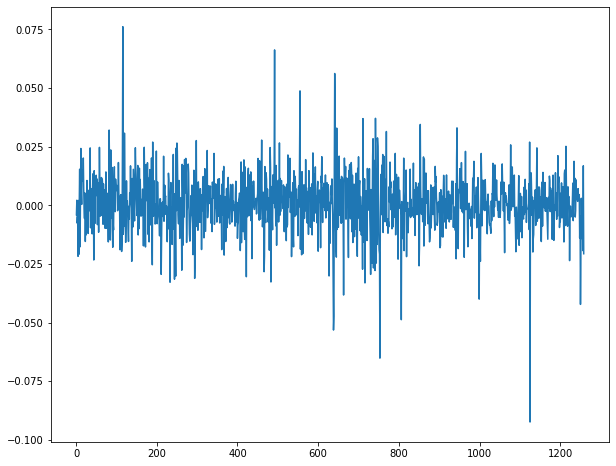

In [26]:
plt.figure(figsize=(10,8))
plt.plot(df['return'])

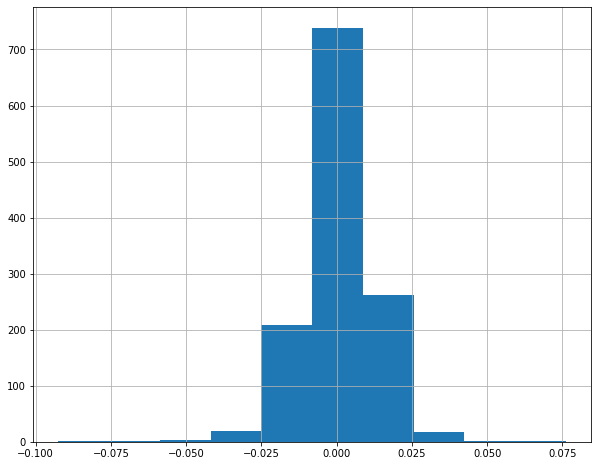

In [27]:
# Now let's try an LSTM to predict returns
plt.figure(figsize=(10,8))
df['return'].hist()

In [28]:
series = df['return'].values[1:].reshape(-1, 1)
# Normalize the data
# Note I didn't think about where the true boundary is, this is just approx
scalar = StandardScaler()
scalar.fit(series[:len(series) // 2])
series = scalar.transform(series).flatten()

In [29]:
# build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1) # make it N x T x D
Y = np.array(Y).reshape(-1,1)
N = len(X)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (1238, 20, 1), Y.shape: (1238, 1)


In [30]:
# Instantiate the model
model = RNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [31]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [32]:
# make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [33]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [34]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 1.1136, Test Loss: 1.0876
Epoch 10/200, Train Loss: 1.0545, Test Loss: 1.0677
Epoch 15/200, Train Loss: 1.0509, Test Loss: 1.0864
Epoch 20/200, Train Loss: 1.0534, Test Loss: 1.0913
Epoch 25/200, Train Loss: 1.0469, Test Loss: 1.0812
Epoch 30/200, Train Loss: 1.0444, Test Loss: 1.0750
Epoch 35/200, Train Loss: 1.0448, Test Loss: 1.0738
Epoch 40/200, Train Loss: 1.0438, Test Loss: 1.0748
Epoch 45/200, Train Loss: 1.0422, Test Loss: 1.0774
Epoch 50/200, Train Loss: 1.0413, Test Loss: 1.0803
Epoch 55/200, Train Loss: 1.0406, Test Loss: 1.0813
Epoch 60/200, Train Loss: 1.0396, Test Loss: 1.0807
Epoch 65/200, Train Loss: 1.0387, Test Loss: 1.0805
Epoch 70/200, Train Loss: 1.0379, Test Loss: 1.0815
Epoch 75/200, Train Loss: 1.0371, Test Loss: 1.0834
Epoch 80/200, Train Loss: 1.0363, Test Loss: 1.0853
Epoch 85/200, Train Loss: 1.0355, Test Loss: 1.0865
Epoch 90/200, Train Loss: 1.0347, Test Loss: 1.0872
Epoch 95/200, Train Loss: 1.0339, Test Loss: 1.0880
Epoch 100/200

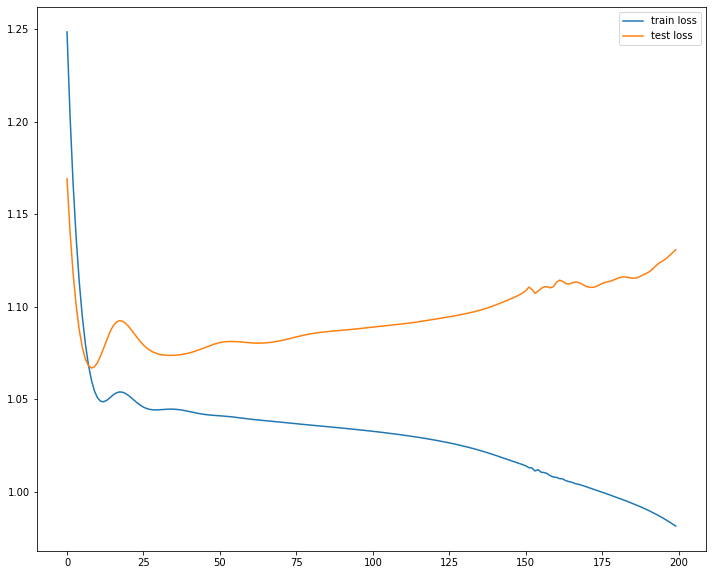

In [35]:
# plot the train loss and test loss per iteration
plt.figure(figsize=(12,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [36]:
# "wrong" one-step forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0
X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)
while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(1,T,1)
  p = model(input_)[0,0].item() # 1x1 arry -> scalar
  i += 1
  # update the predictions list
  validation_predictions.append(p)

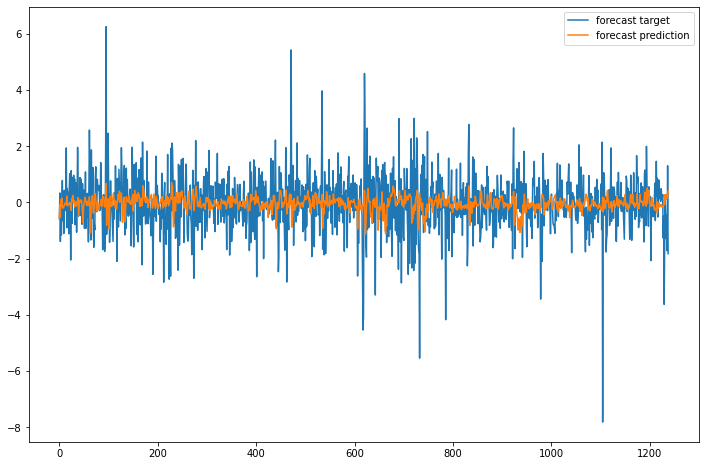

In [37]:
plt.figure(figsize=(12,8))
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()

In [38]:
# Multi-step forecast
# Forecast future values (use only self-predictions for making future predictions)
validation_target = Y[-N//2:]
validation_predictions = []
# last train input
# last_x = torch.from_numpy(X[-N//2]) # 1-D array of length T
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = X_test[0].view(T)
while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1,T,1)
  p = model(input_) # [0,0] 1x1 array -> scalar
  # update the predictions list
  validation_predictions.append(p[0,0].item())
  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

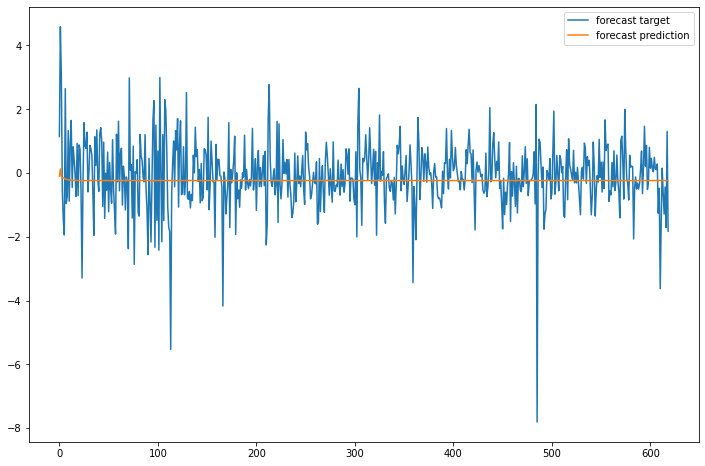

In [39]:
plt.figure(figsize=(12,8))
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()

# Binary Classification

In [40]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


In [41]:
# Now turn the full data into numpy arrays
# Not yet in the final "X" format!
input_data = df[['open','high','low','close','volume']].values
targets = df['return'].values

In [42]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next steps
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T = 10 and you have 11 data points then you)

In [43]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scalar = StandardScaler()
scalar.fit(input_data[:Ntrain + T - 1])
input_data = scalar.transform(input_data)

In [44]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))
for t in range(Ntrain):
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (targets[t+T]>0)

In [45]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))
for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u,:,:] = input_data[t:t+T]
  Y_test[u] = (targets[t+T]>0)

In [46]:
# Instantiate the model
model = RNN(n_inputs=5, n_hidden=50, n_rnnlayers=2, n_outputs=1)
model.to(device)

RNN(
  (rnn): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [47]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [48]:
# make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

In [49]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [51]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test, epochs=300)

Epoch 5/300, Train Loss: 0.0221, Test Loss: 2.5769
Epoch 10/300, Train Loss: 0.0134, Test Loss: 2.6860
Epoch 15/300, Train Loss: 0.0081, Test Loss: 2.8417
Epoch 20/300, Train Loss: 0.0053, Test Loss: 2.9351
Epoch 25/300, Train Loss: 0.0038, Test Loss: 2.9757
Epoch 30/300, Train Loss: 0.0028, Test Loss: 3.0644
Epoch 35/300, Train Loss: 0.0022, Test Loss: 3.1226
Epoch 40/300, Train Loss: 0.0018, Test Loss: 3.1849
Epoch 45/300, Train Loss: 0.0015, Test Loss: 3.2417
Epoch 50/300, Train Loss: 0.0013, Test Loss: 3.2781
Epoch 55/300, Train Loss: 0.0012, Test Loss: 3.3085
Epoch 60/300, Train Loss: 0.0011, Test Loss: 3.3338
Epoch 65/300, Train Loss: 0.0010, Test Loss: 3.3542
Epoch 70/300, Train Loss: 0.0009, Test Loss: 3.3732
Epoch 75/300, Train Loss: 0.0009, Test Loss: 3.3929
Epoch 80/300, Train Loss: 0.0008, Test Loss: 3.4141
Epoch 85/300, Train Loss: 0.0008, Test Loss: 3.4336
Epoch 90/300, Train Loss: 0.0007, Test Loss: 3.4534
Epoch 95/300, Train Loss: 0.0007, Test Loss: 3.4709
Epoch 100/300

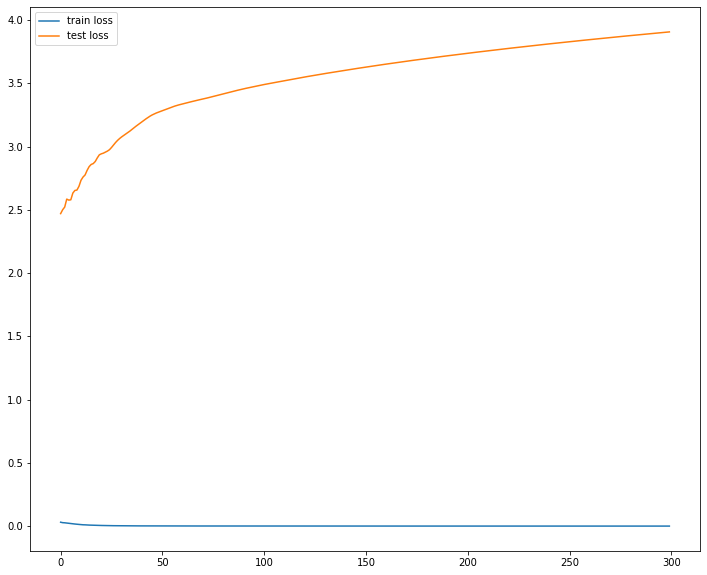

In [52]:
# plot the train loss and test loss per iteration
plt.figure(figsize=(12,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [53]:
# Get accuracy
with torch.no_grad():
  p_train = model(X_train)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train.cpu().numpy() == p_train)

  p_test = model(X_test)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test.cpu().numpy() == p_test)

print(f"Train acc; {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc; 1.0000, Test acc: 0.4951
